In [66]:
%reset

In [67]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [68]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["text.usetex"] = False          # use MathText
rcParams["mathtext.fontset"] = "cm"      # Computer Modern math
rcParams["font.family"] = "serif"
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn
import warnings
from sbi.inference.posteriors import DirectPosterior
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.utils import clip_grad_norm_

# torch.set_printoptions(precision=10, sci_mode=True)

%matplotlib inline

In [69]:
# Isotropic Background without mock_observe applied, generated using AEGIS
with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/data_iso_BG_no_mock_osberve.pkl', 'rb') as f:
    data_iso_BG = pickle.load(f) 

# Spectrum (unnormalized) of Isotropic Background computed from first principles
E_GeV_first_principles = np.load('bin_edges_E_GeV.npy')
spectrum_unormalized_dNdE_GeV_first_principles =  np.load('spectrum_dNdE_GeV.npy')



print(f"Number of photons in test dataset = {data_iso_BG['energies'].size}")

Number of photons in test dataset = 792841


In [71]:
N_Ebins = 100
# center_mask = 0 # 60 #deg
# lat_mask = 0 # 30 #deg 
energy_range_MeV = np.array([1_000.0, 100_000.0]) # MeV
energy_range_GeV = energy_range_MeV / 1e3 # GeV

In [ ]:
# N_side = 64
# N_pix = 12*N_side**2
# pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
# roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]
# print(f"Is pix_i == roi_pix_i ? {np.array_equal(pix_i, roi_pix_i)}")

def generate_spectrum(photon_info, normalize=False): # 'normalize' is a boolean scalar
    # Generates normalized spectrum
    
    # photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
    # print(f"photon_pixels = {photon_pixels}")

    # roi_mask = np.isin(photon_pixels, roi_pix_i)
    # print(f"Number of 'False' entries in roi_mask = {np.count_nonzero(~roi_mask)}; for full sky expect this value to be 0")
    energies_in_roi_MeV = photon_info['energies'] # MeV
    # energies_in_roi_MeV = photon_info['energies'][roi_mask] # MeV
    energies_in_roi_GeV = energies_in_roi_MeV / 1e3 # GeV

    print(f"energy_range = [{energy_range_GeV[0], energy_range_GeV[1]}] GeV")
    print(f"energies_in_roi_GeV.min() = {energies_in_roi_GeV.min()}; energies_in_roi_GeV.max()= {energies_in_roi_GeV.max()}")

    bin_edges_GeV = np.geomspace(energy_range_GeV[0], energy_range_GeV[1], N_Ebins + 1)
    counts, _ = np.histogram(energies_in_roi_GeV, bins=bin_edges_GeV)
    spectrum_GeV = counts / (bin_edges_GeV[1:] - bin_edges_GeV[:-1]) # units: photon / GeV
    Es_GeV = np.sqrt(bin_edges_GeV[:-1] * bin_edges_GeV[1:]) # Find geometric centers of bins

    if normalize == True:
        spectrum_normalized_GeV = spectrum_GeV / energies_in_roi_GeV.size # unnormalized spectrum / number of photons
        return spectrum_normalized_GeV, Es_GeV
    elif normalize == False:
        return spectrum_GeV, Es_GeV


    

energy_range = [(np.float64(1.0), np.float64(100.0))] GeV
energies_in_roi_GeV.min() = 1.0; energies_in_roi_GeV.max()= 99.22009989889179


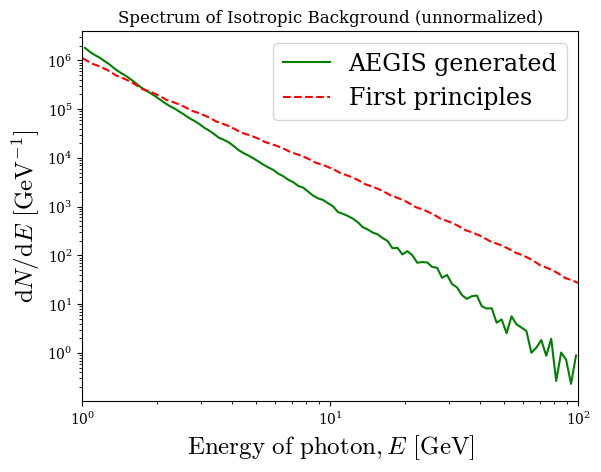

In [ ]:
spectrum_GeV, E_GeV = generate_spectrum(data_iso_BG, normalize=False)


plt.loglog(E_GeV, spectrum_GeV, color='green', label='AEGIS generated')
plt.loglog(E_GeV_first_principles, spectrum_unormalized_dNdE_GeV_first_principles, color='red', linestyle='dashed', label='First principles')

plt.xlabel(r'$\mathrm{Energy\ of\ photon, }E\ \mathrm{ [GeV]}$', fontsize=18)
plt.ylabel(r'$\mathrm{d}N / \mathrm{d}E\ [\mathrm{GeV}^{-1}]$', fontsize=18)
plt.xlim(1, 100)
plt.title('Spectrum of Isotropic Background (unnormalized)')
plt.legend(fontsize=17)
plt.show()